In [397]:
using PyPlot

In [398]:
#=
    Type of the point in the Cartesian coordinate system
=#
type Point{T <: Real}
    x::T
    y::T
    z::T
end

#=
    Type of the cluster with center and points,
    which belongs to its set
=#
type Cluster 
    center::Point
    points::Array{Point, 1}
end

In [399]:
#=
    Function that returns array of arrays
    of string values by reading of .csv file
=#
function getDataSetFromCSV(filename::String)::Array{Array{String, 1}, 1}
    arrayOfData::Array{Array{String, 1}, 1} = []
    open(filename) do file   
        for line::String in eachline(file)
          push!(arrayOfData, split(line, ','))  
        end    
    end   
    arrayOfData
end    

#=
    Function that converts array of arrays
    of string values to the 2-dimensional array
    of parsed values to float format 
=#
function convertToFloatData(array::Array{Array{String, 1}, 1},
     rowNumber::Int64, colNumber::Int64)::Array{Float64, 2}
    arrayOfFloats = Array{Float64, 2}(rowNumber, colNumber)
    for i::Int64 = 1 : rowNumber
        for j::Int64 = 1 : colNumber
            arrayOfFloats[i, j] = parse(Float64, array[i][j]) 
        end
    end    
    arrayOfFloats
end

#=
    Function that gets index of the column from dataset
    by its name (if it contains it)    
=#
function getColumnIndexByName(array::Array{Array{String, 1}, 1},
     colName::String)::Int64 
    for i::Int64 = 1 : size(array[1], 1)
        if(array[1][i] == colName)           
            return i
        end
    end   
    return -1
end

#=
    Function that returns column's data by its index in dataset    
=#
function getDataFromColumnByIndex(array::Array{Array{String, 1}, 1},
     index::Int64)::Array{Float64, 1} 
    dataFromColumn = Array{Float64, 1}(0)
    for i::Int64 = 2 : size(array, 1)
        push!(dataFromColumn, parse(Float64, array[i][index])) 
    end   
    dataFromColumn
end

#=
    Function that returns column's data by its name in dataset    
=#
function getDataFromColumnByName(array::Array{Array{String, 1}, 1},
     colName::String)::Array{Float64, 1}       
    dataFromColumn = Array{Float64, 1}(0);
    colIndex::Int64 = getColumnIndexByName(array, colName) 
    for i::Int64 = 2 : size(array, 1)          
        push!(dataFromColumn, parse(Float64, array[i][colIndex])) 
    end   
    dataFromColumn
end

#=
    Function that links columns of the dataset into 2-d matrix
=#
function linkData(arrays...)::Matrix{Float64}
    result = Matrix{Float64}(size(arrays[1], 1), length(arrays))
    for i::Int64 = 1 : size(arrays[1], 1)
        for j::Int64 = 1 : length(arrays)
            result[i, j] = arrays[j][i]
        end
    end    
    result
end

#=
    Function that creates array of the points based on the chosen dataset,
    represented in 2-d matrix
=#
function determinePoints(dataset::Matrix{Float64})::Array{Point, 1}
    len::Int64 = size(dataset, 1)
    points = Array{Point, 1}(len)  
    for i::Int64 = 1 : len
        point = Point(dataset[i, 1], dataset[i, 2], dataset[i, 3])      
        points[i] = point      
    end  
    points
end

#=
    Function that creates array of points' projections
    based on the selected axis ("x", "y", "z")
=#
function getPointsProjections(points::Array{Point, 1},
     axis::String)::Array{Float64, 1}
    coords = Array{Float64, 1}(0)
    for p::Point in points
        if(lowercase(axis) == "x")
            push!(coords, p.x)
        elseif(lowercase(axis) == "y")
            push!(coords, p.y)
        elseif(lowercase(axis) == "z")
            push!(coords, p.z)
        else    
            push!(coords, 0.0)      
        end
    end
    coords
end

#=
    Function that returns point by random index
    from the array of points   
=#
function getRandomPoint(points::Array{Point, 1})::Point
    index::Int64 = rand(1: size(points, 1))
    points[index];
end

#=
    Function that creates initial clusters   
=#
function defineInitialClusters(clustersCount::Int64, points::Array{Point, 1})::Array{Cluster, 1}
    clusters = Array{Cluster, 1}(clustersCount)    
    for i = 1 : clustersCount
        center = getRandomPoint(points)
        cluster = Cluster(center, [center])
        clusters[i] = cluster
    end
    clusters
end

#=
    Function that returns distance between two points 
=#
function distance(point1::Point, point2::Point)::Float64   
    norm([point1.x, point1.y, point1.z] - [point2.x, point2.y, point2.z])    
end

#=
    Function that returns distances' matrix based on distances between
    clusters' centers and all the points
=#
function getDistanceMatrix(points::Array{Point, 1}, clusters::Array{Cluster, 1})::Matrix{Float64}
    distanceMatrix = Matrix{Float64}(length(points), length(clusters))
    for i::Int64 = 1 : length(points)
        for j::Int64 = 1 : length(clusters)
            distanceMatrix[i, j] = distance(points[i], clusters[j].center)
        end
    end    
    distanceMatrix
end

#=
    Function that compares two points by their coordinates  
=#
function comparePointsCoordinates(point1::Point, point2::Point)
   point1.x == point2.x && point1.y == point2.y && point1.z == point2.z
end

#=
    Function that returns new center of the cluster as the center of mass   
=#
function getNewClusterCenter(cluster::Cluster)::Point   
    x::Float64 = reduce(+, getPointsProjections(cluster.points, "x")) / length(cluster.points)
    y::Float64 = reduce(+, getPointsProjections(cluster.points, "y")) / length(cluster.points)
    z::Float64 = reduce(+, getPointsProjections(cluster.points, "z")) / length(cluster.points)    
    Point(x, y, z)    
end

#=
    Function that makes one iteration of the clustering 
=#
function kmeansIteration(clusters::Array{Cluster, 1}, points::Array{Point, 1})::Bool 
    status::Bool  = false;     
    distanceMatrix::Matrix{Float64} = getDistanceMatrix(points, clusters)      
    for i::Int64 = 1 : size(distanceMatrix, 1)
        minIndex::Int64 = indmin(distanceMatrix[i, 1 : size(distanceMatrix, 2)])  
        if(!(points[i] in clusters[minIndex].points))            
            push!(clusters[minIndex].points, points[i])    
        end
        for j::Int64 = 1 : size(distanceMatrix, 2)
            if(j != minIndex && (points[i] in clusters[minIndex].points))                                 
                clusters[j].points = filter!(pnt -> pnt != points[i], clusters[j].points)                     
            end
        end      
    end
    for cl::Cluster in clusters
        newCenter::Point = getNewClusterCenter(cl)
        if(comparePointsCoordinates(cl.center, newCenter))
           status = true; 
        else
           cl.center = newCenter
        end
    end
    status   
end

#=
    Function that draws chart based on the sets of the clusters' points
=#
function drawChart(clusters::Array{Cluster, 1})
    for cluster::Cluster in clusters
        plot(getPointsProjections(cluster.points, "x"), 
            getPointsProjections(cluster.points, "y"), "o")
    end    
end

drawChart (generic function with 1 method)

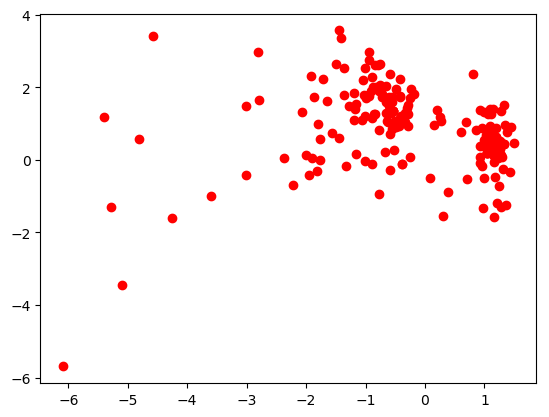

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000036E43588>

In [400]:
# Reading data from .csv file
fileData = getDataSetFromCSV("creditcard.csv")

# Getting values from data as the array of coordinates 
xs = getDataFromColumnByName(fileData, "\"V1\"")
ys = getDataFromColumnByName(fileData, "\"V3\"")
# Uncomment this for only 'X' and 'Y' axis
zs = zeros(getDataFromColumnByName(fileData, "\"V6\""))
# zs = getDataFromColumnByName(fileData, "\"V6\"")

# Build chart based on all points
axis("auto")
plot(xs, ys, "ro")

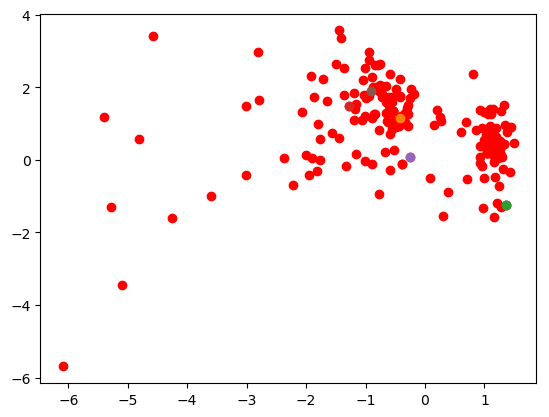

In [401]:
# Creating final dataset based on arrays of coordinates
dataset = linkData(xs, ys, zs)

# Creating points according to the following dataset
points = determinePoints(dataset)

# Defining count of the clusters
clustersCount = 6

# Creating inital clusters
clusters = defineInitialClusters(clustersCount)

# First iteration results and chart
plot(xs, ys, "ro")
drawChart(clusters)

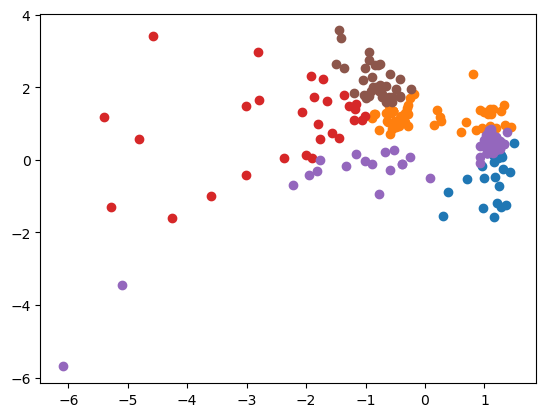

In [402]:
# First iteration results and chart
kmeansIteration(clusters, points)
drawChart(clusters)

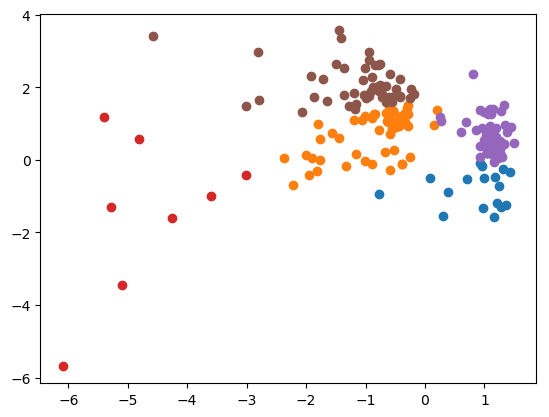

`Iterations: 7`


In [403]:
counter = 1;
# Do clustering until clusters' centers will change
while(!kmeansIteration(clusters, points))  
    counter += 1
end
println(`Iterations: $counter`)

# Chart based on last iteration
drawChart(clusters)